In [156]:
import numpy as np
import pandas as pd

from time import time
from datetime import timedelta

import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL, seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, max_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, clear_output

In [2]:
def print_elapsed_time(start):
    elapsed = timedelta(seconds=time() - start)
    # remove millis
    elapsed = str(elapsed).split('.')[0]
    print('Elapsed time: {}'.format(elapsed))

# Data collection

The data is automatically converted to hourly

In [3]:
def read_tide(filepath, datetime_pattern=slice(0,13)):
    df = pd.read_csv(filepath)
    df['Date Time'] = [date[datetime_pattern] for date in df['Date Time']]
    df['Date Time'] = pd.to_datetime(df['Date Time'])
    df = df.groupby(['Date Time']).mean()
    return df.reset_index()

In [4]:
orig_train = read_tide('BHPtraining.csv')
orig_test = read_tide('BHPtest.csv')

# Data cleaning

## Merging data and test

Merging back train and test data for easy differencing

,Date Time,Air Temperature,Water Level,Water Level Sigma,Wind Speed,Wind Direction,Wind Gust
0,2017-01-01 00:00:00,63.900000,2.447500,0.149200,4.860000,136.111111,5.355556
1,2017-01-01 01:00:00,63.980000,2.246100,0.162900,4.237000,134.200000,4.666000
2,2017-01-01 02:00:00,64.180000,2.250600,0.153900,5.073000,129.700000,5.404000
3,2017-01-01 03:00:00,64.300000,2.102700,0.160800,5.015000,112.200000,5.287000
4,2017-01-01 04:00:00,64.180000,2.027900,0.168600,6.725000,82.800000,7.115000
...,...,...,...,...,...,...,...
7053,2020-10-20 21:00:00,80.440000,1.858000,0.385200,12.091000,74.600000,13.783000
7054,2020-10-20 22:00:00,79.770000,2.366700,0.380500,12.206000,78.600000,13.898000
7055,2020-10-20 23:00:00,79.430000,2.721800,0.384300,12.497000,74.900000,14.228000
7056,2020-10-21 00:00:00,79.320000,2.967100,0.399600,13.431000,78.600000,15.298000


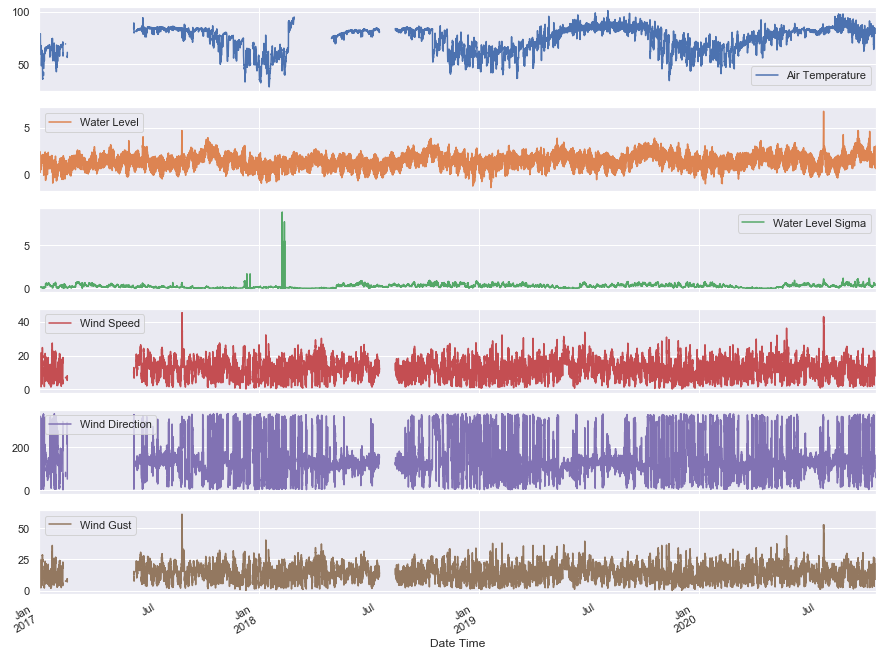

In [235]:
merged = pd.concat([orig_train, orig_test])
merged.plot(x='Date Time', figsize=(15, 12), subplots=True)
merged

## Fill missing values

Filling missing values with respect to the seasonality. This part of code is written by Xiaojun Qiao.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F9DB5EF648>,
      dtype=object)

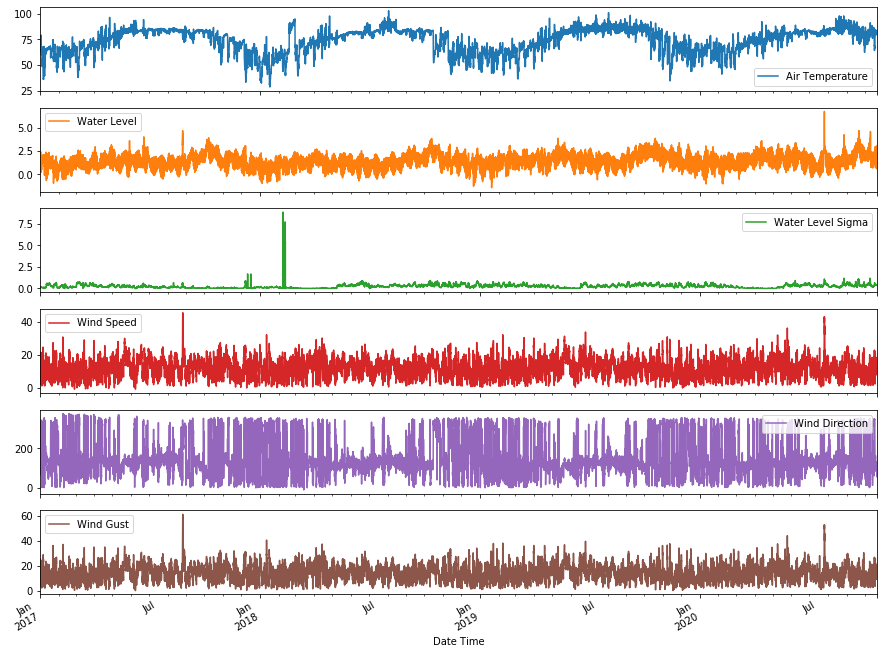

In [8]:
preprocessed = merged.copy().set_index('Date Time')
for key in preprocessed.keys():
    temp = preprocessed[key]
    nan_index = temp.isnull()
    temp = temp.interpolate('linear')
    results = seasonal_decompose(temp,period=24*30*12, model='additive', extrapolate_trend='freq')
    for i, real in enumerate(nan_index):
        if real == True:
            results.trend.iloc[i] = np.nan
            dt = '2019-' + str(results.resid.index[i])[5:]
            results.seasonal.iloc[i] = results.seasonal.loc[dt]
            results.resid.iloc[i] = results.resid.loc[dt]
    preprocessed[key] = results.trend.interpolate('linear') + results.seasonal + results.resid

preprocessed.reset_index(inplace=True)    

preprocessed.plot(x = 'Date Time', figsize=(15, 12), subplots=True)

## Stationary  test

Since one of the requirements of SARIMA is stationary, we should do the test first

In [9]:
def stationary_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [10]:
water_level_df = preprocessed[['Date Time', 'Water Level']].copy().set_index('Date Time')
water_level_df.dropna(inplace=True)
stationary_test(water_level_df['Water Level'].values)

ADF Statistic: -8.366553
p-value: 0.000000


The p-value is significant enough, so it might be tempted to conclude that the data is already stationary.  

However, we know that the data should be seasonal, as in below

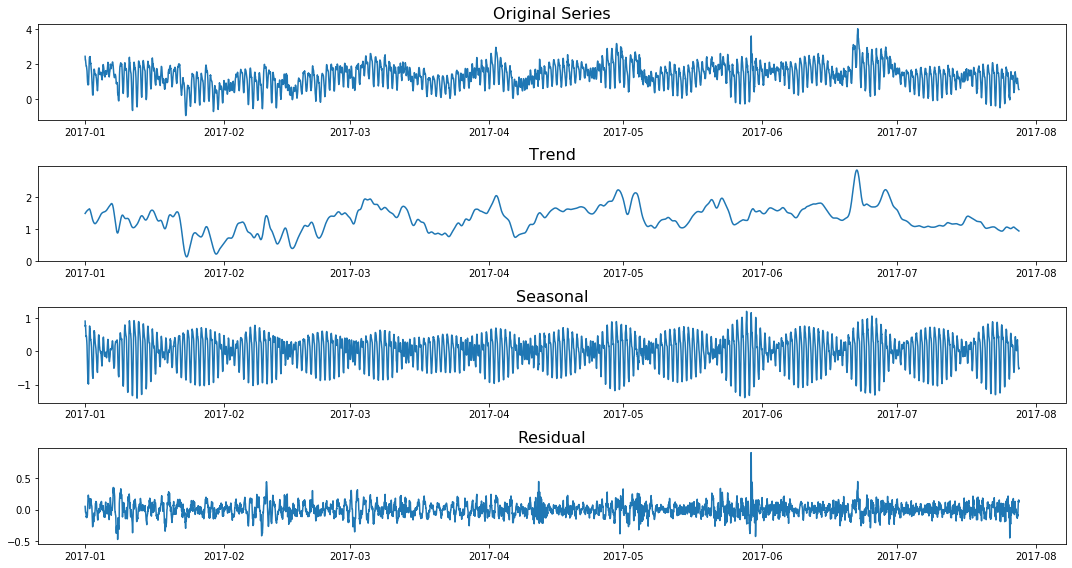

In [11]:
first_5k_obs = water_level_df['Water Level'][:5000]

stl = STL(first_5k_obs)
result = stl.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid

plt.figure(figsize=(15,8))

plt.subplot(4,1,1)
plt.plot(first_5k_obs)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Performing differencing

Basically, I remove the daily part, then the annually part.

(Admittedly, this might not be a smart choice, I should've used the Integrated parameters of the model, instead of manually messing with this) 

ADF Statistic: -20.239350
p-value: 0.000000


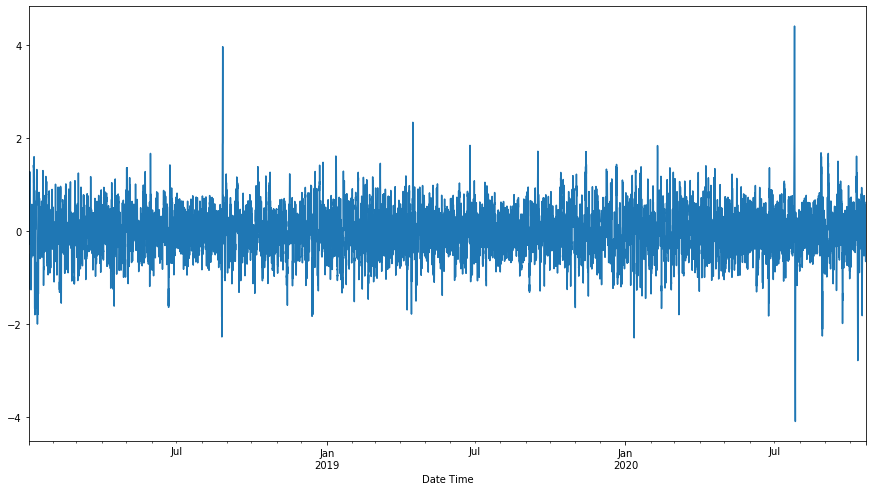

In [12]:
diff_merged = preprocessed.copy()

diff_merged = diff_merged.bfill().ffill().interpolate()
diff_merged.set_index('Date Time', inplace=True)

diff_merged = diff_merged.diff(periods=24)[1:]              # by 1 day
diff_merged = diff_merged.diff(periods=365*24).dropna()     # by 1 year

wl_df = diff_merged['Water Level']
stationary_test(wl_df)
wl_df.plot(x='Date Time', figsize=(15,8))

# diff_merged.plot(figsize=(15, 12), subplots=True)

### Splitting back into train and test set

In [13]:
boundary = pd.to_datetime('2020/01/01')
train = diff_merged[:boundary-timedelta(days=1)]
test = diff_merged[boundary:]

In [14]:
wl_train = pd.DataFrame(train['Water Level'])
wl_test = pd.DataFrame(test['Water Level'])

## ACF and PACF

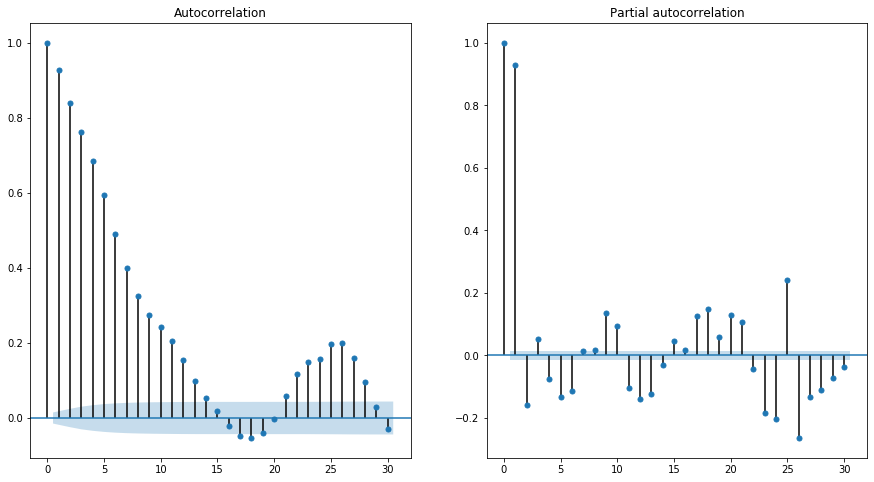

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
lags = 30
sm.graphics.tsa.plot_acf(wl_train, lags=lags, ax=ax[0], title='Autocorrelation')
sm.graphics.tsa.plot_pacf(wl_train, lags=lags, ax=ax[1], title='Partial autocorrelation')
pass

For ACF, we can see that 25 is the most significant lag, so let's try with seasonality of around 24-25.

(To be honest, I'm still quite confused about this choosing parameter part)

# SARIMA model

In [16]:
def train_sarima(df, periodicity=24, p=1, q=1, trend=None, track_time=False):
    model = SARIMAX(df, order=(0,1,0), seasonal_order=(p,0,q,periodicity), trend=trend)

    #fit the model
    start = time()
    model_fit = model.fit()
    end = time()
    if track_time:
        print('Model Fitting Time:', end - start)
    
    return model_fit

### Brute-force

Let's calculate the AIC of some reasonable periods

In [17]:
periods = [6,12,18,24,25]
for period in periods:
    model = train_sarima(wl_train['Water Level'].values, period)
    print('{} {}'.format(period, model.aic))

6 -10663.603623458795
12 -12182.544265754028
18 -10817.024915202173
24 -13553.8247153439
25 -12483.64153879625


Since a period 24 hours gives lowest value of AIC, we'll try both 24 and 25.

**Clarification**: Above is actually what I did at first, but then I realized I should also try with different values of p and q, so I also tried brute-force with a bunch of parameters (in another notebook, forgot to copy it here), and (6,0,6)<sub>4</sub> actually has a much lower AIC than (1,0,1)<sub>24</sub>. So, in the end, I implemented all these 3 models.

In [18]:
model = train_sarima(wl_train['Water Level'].values)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                17473
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 24)   Log Likelihood                6779.911
Date:                              Wed, 04 Nov 2020   AIC                         -13553.823
Time:                                      14:20:51   BIC                         -13530.518
Sample:                                           0   HQIC                        -13546.148
                                            - 17473                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.6714      0.005    123.535      0.000       0.661       0.682
ma.S.L24      -1.0000      0.265     -3.775      0.000      -1.519      -0.481
sigma2         0.0268      0.007      3.791      0.000       0.013       0.041
===================================================================================
Ljung-Box (L1) (Q):                 849.03   Jarque-Bera (JB):              1691.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# get the predictions and residuals
predictions = model.forecast(len(wl_test)+1)
predictions = pd.DataFrame(predictions[1:], columns=['Water Level'], index=wl_test.index)
residuals = wl_test - predictions
# predictions

,Water Level
count,7058.000000
mean,0.000985
std,0.542170
min,-4.094483
25%,-0.308558
50%,0.003617
75%,0.330954
max,4.411317


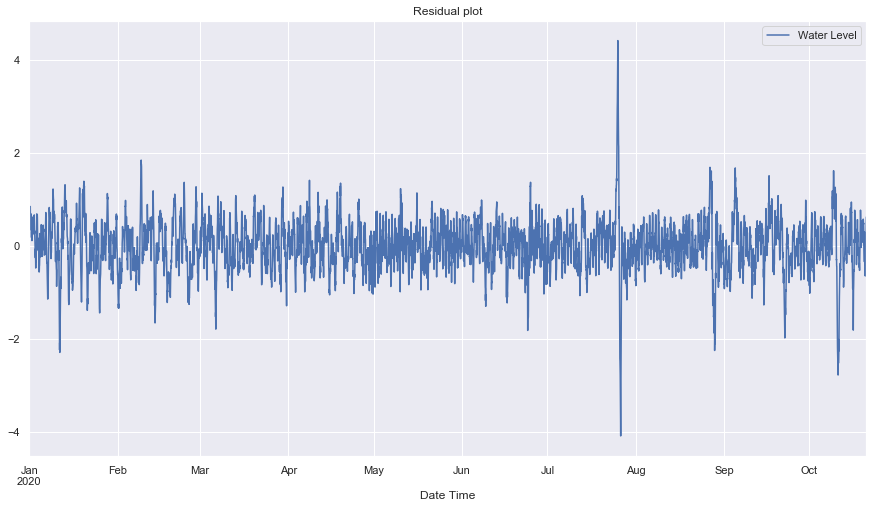

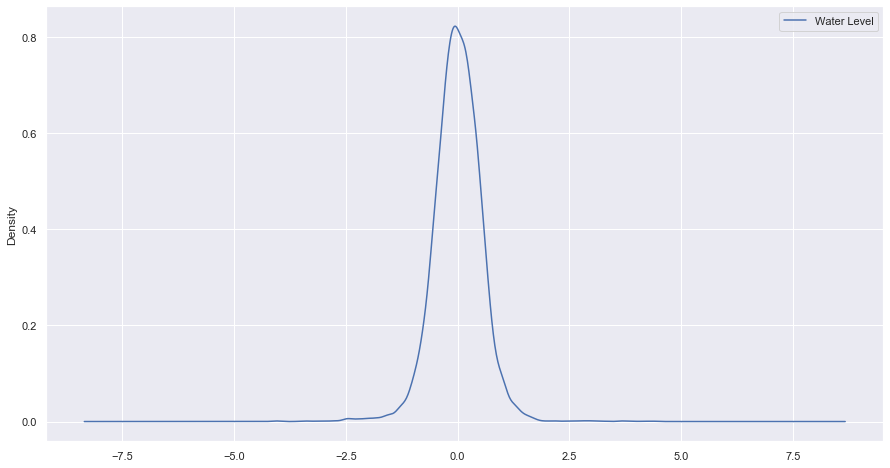

In [239]:
residuals.plot(figsize=(15,8), title='Residual plot')
residuals.plot(kind='kde', figsize=(15,8))
residuals.describe()

## Plotting predictions

In [192]:
def getOnlyNoonAndMidnight(df):
    hours = df.index.hour
    return df[(hours == 0) | (hours == 12)]

In [195]:
def plot_prediction(y_true, y_pred, undiff=False, true_label_first=True):
    # since we applied differencing earlier, it might be better if we revert them back
    if undiff:
        y_true = reconstruct(y_true)
        y_pred = reconstruct(y_pred)
        
    y_true = getOnlyNoonAndMidnight(y_true)
    y_pred = getOnlyNoonAndMidnight(y_pred)
    
    plt.figure(figsize=(15,8))

    true_color = '#4C72B0'
    pred_color = '#D48861'
    if true_label_first:
        plt.plot(y_true, color=true_color, label='Data')
        plt.plot(y_pred, color=pred_color, label='Predictions')
    else:
        plt.plot(y_pred, color=pred_color, label='Predictions')
        plt.plot(y_true, color=true_color, label='Data')
    
    plt.legend(loc='upper right', fontsize=16)
    plt.title('Water level data in 2020', fontsize=20)
    plt.ylabel('Water level', fontsize=16)
    
    # those vertical month lines
    first_month = y_pred.index[0].month
    last_month = y_pred.index[-1].month
    for month in range(first_month,last_month+1):
        plt.axvline(pd.to_datetime('2020-' + str(month) + '-01'), color='k', linestyle='--', alpha=0.2)

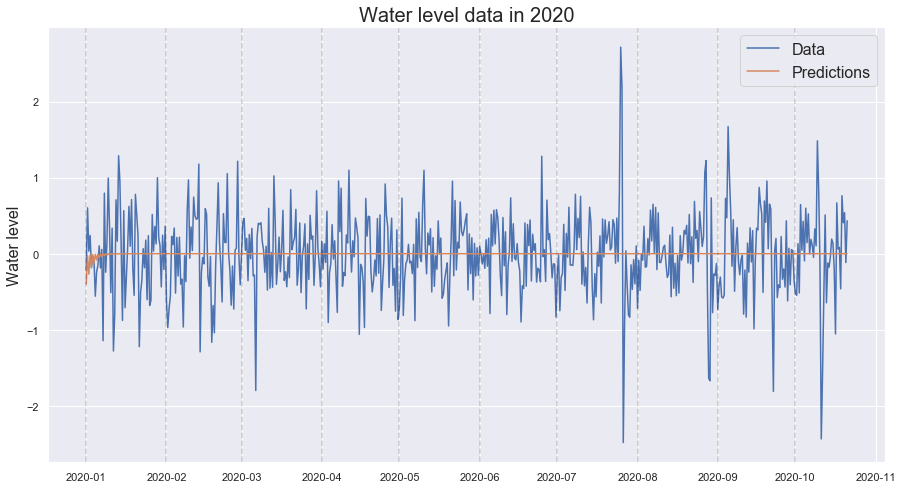

In [196]:
plot_prediction(wl_test, predictions)

We could clearly see that the prediction doesn't work quite well. I guess the model probably isn't suitable for predicting large amount of data.

## Evaluation

In [23]:
def undiff(arr, step=24):
    arr = arr.copy()
    for i in range(step, len(arr)):
        arr[i] += arr[i-step]
    return arr

def reconstruct(df):
    first_diff = orig_train.copy().set_index('Date Time')
    first_diff = first_diff.bfill().ffill().interpolate()
    first_diff = first_diff.diff(periods=24).dropna()
    
    # revert 1 year differencing
    res = df.values.copy()
    res = np.append(first_diff['Water Level'][-365*24:], res)
    res = undiff(res, 365*24)[365*24:]

    # revert 1 day differencing
    res = np.append(orig_train['Water Level'][-24:], res)
    res = undiff(res, 24)[24:]
    
    return pd.DataFrame(res, columns=['Water Level'], index=df.index)

In [210]:
def evaluate(pred, test, model='', undiff=False):
    # since we applied differencing earlier, it might be better if we revert them back
    if undiff:
        pred = reconstruct(pred)
        test = reconstruct(test)
        
    test = getOnlyNoonAndMidnight(test)
    pred = getOnlyNoonAndMidnight(pred)
    
    mse = mean_squared_error(test, pred)
    r2 = r2_score(test, pred)
    mae = mean_absolute_error(test, pred)
    medae = median_absolute_error(test, pred)
    max_err = max_error(test, pred)
    # me = (test.values - pred.values).mean()
    
    errors = {'MSE': mse, 'RMSE': sqrt(mse), 'R2': r2, 'MAE': mae, \
              'MedAE': medae, 'MaxErr': max_err, 'Un-difference?': undiff}
    
    eval_df = pd.DataFrame(errors, index=[model]).round(3)
    return eval_df

In [211]:
evaluate(wl_test, predictions)

,MSE,RMSE,R2,MAE,MedAE,MaxErr,Un-difference?
,0.286,0.535,-585.656,0.4,0.316,2.714,False


As expected, the R<sup>2</sup> metric is pretty bad.

## Using the Rolling Forecast Origin

Since the above implementation didn't work, I decided to do a rolling forecast.  
Basically, it builds the  model, then predicts one day, then rebuilds the model, then predicts the next day, and so on.

The first model is with m = 24, which is the number of time steps for a single seasonal period.

In [55]:
def rolling_forecast_sarima(train, test, m=24, order=(0,0,0), seasonal_order=(1,0,1,25), steps=24):
    history = [x for x in train['Water Level'].values]
    future = test['Water Level'].copy()
    rolling_pred = list()

    # time tracking
    start = time()

    total_steps = int(len(wl_test) / steps)

    for t in range(total_steps):
        print("Date: {}/{}".format(t, total_steps))
        print_elapsed_time(start)

        # train
        model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()

        # predict
        output = model_fit.forecast(steps)
        yhat = output
        rolling_pred.extend(yhat)

        # update training data with current day
        obs = future[t*steps:(t+1)*steps].values
        history.extend(obs)

        clear_output(wait=True)
        # print(str(t) + '\npredicted={}\nexpected={}'.format(yhat, obs))

    clear_output(wait=True)
    print_elapsed_time(start)
    
    return rolling_pred

### SARIMA(0,1,0)(1,0,1)<sub>24</sub>

In [43]:
sarima_24_pred = rolling_forecast_sarima(wl_train, wl_test, order=(0,1,0), seasonal_order=(1,0,1,24))

Elapsed time: 1:42:13


In [ ]:
sarima_24_pred_df = pd.DataFrame(sarima_24_pred, columns=['Water Level'], index=wl_test[:len(sarima_24_pred)].index)

In [212]:
eval_sarima_24 = evaluate(wl_test[:len(sarima_24_pred_df)], sarima_24_pred_df, 'SARIMA(0,1,0)(1,0,1,24)')
eval_sarima_24

,MSE,RMSE,R2,MAE,MedAE,MaxErr,Un-difference?
"SARIMA(0,1,0)(1,0,1,24)",0.285,0.534,0.021,0.351,0.195,4.26,False


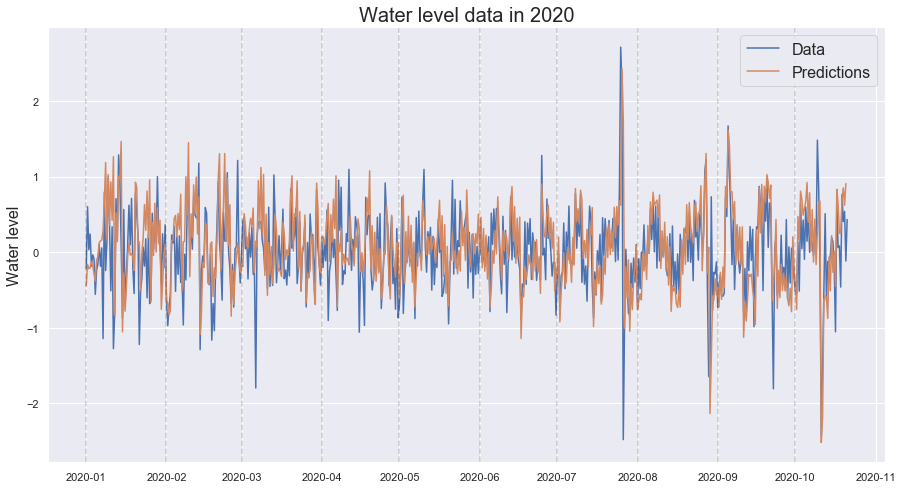

In [202]:
plot_prediction(wl_test, sarima_24_pred_df)

We could see that the prediction is much better, especially in the first half period. Unfortunately, the pattern starts to diverge in the second half period.

### SARIMA(0,1,0)(1,0,1)<sub>25</sub>

In [47]:
sarima_25_pred = rolling_forecast_sarima(wl_train, wl_test, order=(0,1,0), seasonal_order=(1,0,1,25))

Elapsed time: 0:49:58


In [ ]:
sarima_25_pred_df = pd.DataFrame(sarima_25_pred, columns=['Water Level'], index=wl_test[:len(sarima_25_pred)].index)
sarima_25_pred_df

In [240]:
eval_sarima_25 = evaluate(wl_test[:len(sarima_25_pred_df)], sarima_25_pred_df, 'SARIMA(0,1,0)(1,0,1,25)')
eval_sarima_25

,MSE,RMSE,R2,MAE,MedAE,MaxErr,Un-difference?
"SARIMA(0,1,0)(1,0,1,25)",0.39,0.625,-0.373,0.434,0.293,3.476,False


In [243]:
# plot_prediction(wl_test, sarima_25_pred_df)

### SARIMA(0,0,0)(1,0,1)<sub>24</sub>

In [218]:
sarima_0_24_pred = rolling_forecast_sarima(wl_train, wl_test, order=(0,0,0), seasonal_order=(1,0,1,24))

Elapsed time: 0:36:27


,MSE,RMSE,R2,MAE,MedAE,MaxErr,Un-difference?
"SARIMA(0,0,0)(1,0,1,24)",0.706,0.84,-0.239,0.67,0.569,2.865,True


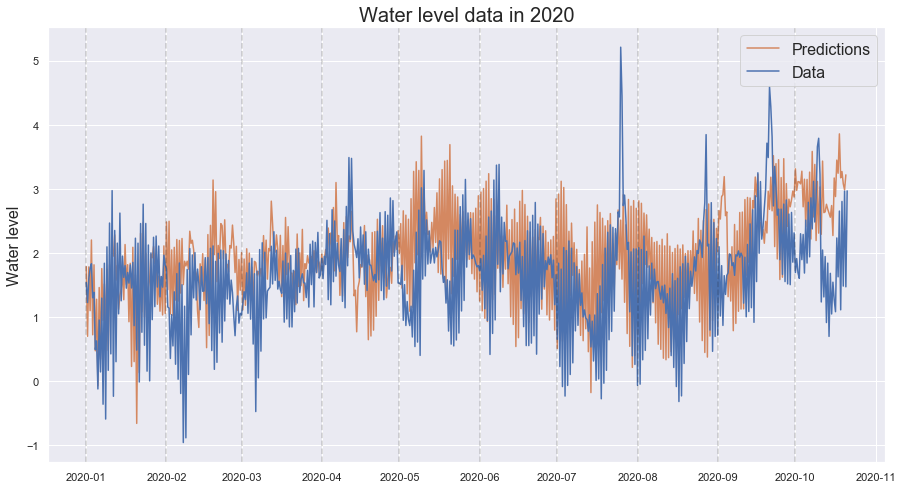

In [221]:
sarima_0_24_pred_df = pd.DataFrame(sarima_0_24_pred, columns=['Water Level'], index=wl_test[:len(sarima_0_24_pred)].index)
sarima_0_24_pred_df

plot_prediction(wl_test, sarima_0_24_pred_df, undiff=True, true_label_first=False)

eval_sarima_0_24 = evaluate(wl_test[:len(sarima_0_24_pred_df)], sarima_0_24_pred_df, 'SARIMA(0,0,0)(1,0,1,24)', undiff=True)
eval_sarima_0_24

### SARIMA(0,0,0)(1,0,1)<sub>25</sub>

In [56]:
sarima_0_25_pred = rolling_forecast_sarima(wl_train, wl_test, order=(0,0,0), seasonal_order=(1,0,1,25))

Elapsed time: 0:56:50


In [244]:
sarima_0_25_pred_df = pd.DataFrame(sarima_0_25_pred, columns=['Water Level'], index=wl_test[:len(sarima_0_25_pred)].index)
sarima_0_25_pred_df

eval_sarima_0_25 = evaluate(wl_test[:len(sarima_0_25_pred_df)], sarima_0_25_pred_df, 'SARIMA(0,0,0)(1,0,1,25)', undiff=True)
eval_sarima_0_25

,MSE,RMSE,R2,MAE,MedAE,MaxErr,Un-difference?
"SARIMA(0,0,0)(1,0,1,25)",0.611,0.782,-0.027,0.632,0.557,2.817,True


In [245]:
# plot_prediction(wl_test, sarima_0_25_pred_df, undiff=True, true_label_first=False)

### SARIMA (0,1,0)(6,0,6)<sub>4</sub>

In [67]:
sarima_664_pred = rolling_forecast_sarima(wl_train, wl_test, order=(0,1,0), seasonal_order=(6,0,6,4))

Elapsed time: 10:12:48


In [ ]:
sarima_664_pred_df = pd.DataFrame(sarima_664_pred, columns=['Water Level'], index=wl_test[:len(sarima_664_pred)].index)
sarima_664_pred_df

,MSE,RMSE,R2,MAE,MedAE,MaxErr,Un-difference?
"SARIMA(0,1,0)(6,0,6,4)",0.225,0.475,-1.664,0.331,0.235,2.797,False


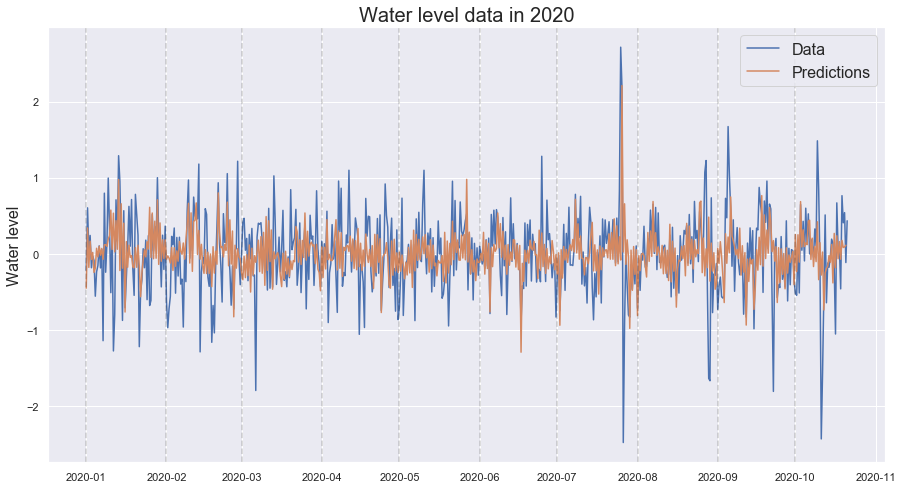

In [215]:
plot_prediction(wl_test, sarima_664_pred_df)

eval_sarima_664 = evaluate(wl_test[:len(sarima_664_pred_df)], sarima_664_pred_df, 'SARIMA(0,1,0)(6,0,6,4)')
eval_sarima_664

# SARIMA with exogenous  variables

## Correlation

In [137]:
def plot_corr(corr):
    sns.set(rc={'figure.figsize':(6,5)})
    ax = sns.heatmap(corr, cmap='Greens', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

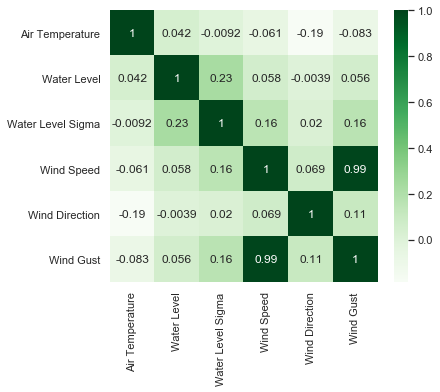

In [138]:
plot_corr(train.corr(method='spearman'))

Looking at the correlation between those attributes, Wind Speed and Wind Gust are highly correlated, so I'll omit Wind Gust here.

## Training basic SARIMAX

In [4]:
# model = SARIMAX(train['Water Level'], exog=train[['Wind Speed', 'Wind Direction']], \
#                 order=(0,1,0), seasonal_order=(1,0,1,24))
# model_fit = model.fit()
# model_fit.summary()

In [31]:
def train_sarimax_model(train, test, exogs, m=24, steps=None):
    history_wl = [x for x in train['Water Level'].values]
    history_exog = [x for x in train[exogs].values]
    future_wl = test['Water Level'].copy()
    future_exog = test[exogs].copy()

    sarimax_pred = list()

    # time tracking
    start = time()

    if steps == None:
        steps = m
    total_steps = int(len(wl_test) / steps)

    for t in range(total_steps):
        print('Date: {}/{}'.format(t, total_steps))
        print_elapsed_time(start)

        # train
        model = SARIMAX(history_wl, exog=history_exog, order=(0,1,0), seasonal_order=(1,0,1,m))
        model_fit = model.fit()

        # predict
        output = model_fit.forecast(steps, exog=future_exog[t:t+steps])
        yhat = output
        sarimax_pred.extend(yhat)

        # add current water level to training data
        obs = future_wl[t*steps:(t+1)*steps].values
        history_wl.extend(obs)
        # also the exog data
        history_exog.extend(future_exog[t*steps:(t+1)*steps].values)

        clear_output(wait=True)
        # print(str(t) + '\npredicted={}\nexpected={}'.format(yhat, obs))

    clear_output(wait=True)
    print_elapsed_time(start)
    
    return sarimax_pred

## SARIMAX(0,1,0)(1,0,1)<sub>24</sub> with Wind Speed and Direction

In [235]:
sarimax_24_wind_pred = train_sarimax_model(train, test, exogs=['Wind Speed', 'Wind Direction'])

Elapsed time: 7:00:19


In [233]:
# I forgot to save the prediction result, so this is just a workaround
# eval_sarimax_24_wind = pd.DataFrame({'MSE': 0.407, 'RMSE': 0.638, 'R2': -0.588, 'MAE': 0.475, 'MedAE': 0.389, \
#                   'Un-difference?': False}, index=['SARIMAX(0,1,0)(1,0,1,24) + Wind'])
# eval_sarimax_24_wind

In [297]:
sarimax_24_wind_pred_df = pd.DataFrame(sarimax_24_wind_pred, columns=['Water Level'], \
                                       index=wl_test[:len(sarimax_24_wind_pred)].index)
# sarimax_24_wind_pred_df

In [385]:
eval_sarimax_24_wind = evaluate(wl_test[:len(sarimax_24_wind_pred_df)], sarimax_24_wind_pred_df, 'SARIMAX_24_wind')
eval_sarimax_24_wind

,RMSE,R2,MSE,ME,MAE,MedAE
sarimax w/ wind,0.638,-0.588,0.407,0.009,0.475,0.389


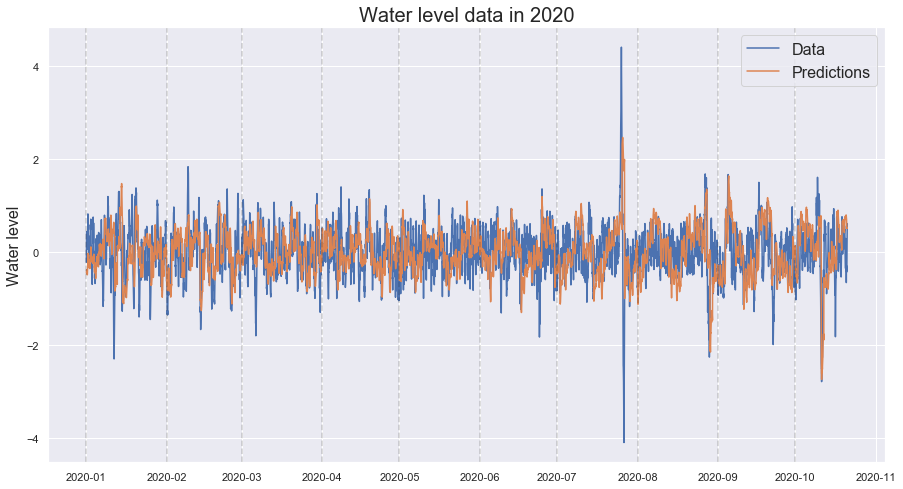

In [246]:
plot_prediction(wl_test, sarimax_pred_df)

The result doesn't have any significant difference from the model SARIMA(0,1,0)(1,0,1)24, while those errors metrics are slightly higher.

## SARIMAX(0,1,0)(1,0,1)<sub>25</sub> with Wind Speed, Water Level Sigma and Air Temp

In [50]:
exogs=['Wind Speed', 'Water Level Sigma', 'Air Temperature']
sarimax_25_full_pred = train_sarimax_model(train, test, exogs=exogs, m=25)

Elapsed time: 5:28:57


In [ ]:
sarimax_25_full_pred_df = pd.DataFrame(sarimax_25_full_pred, columns=['Water Level'], \
                                       index=wl_test[:len(sarimax_25_full_pred)].index)

,MSE,RMSE,R2,MAE,MedAE,MaxErr,Un-difference?
"SARIMAX(0,1,0)(1,0,1,25) + WS-WLS-AT",0.15,0.387,0.244,0.252,0.162,2.725,False


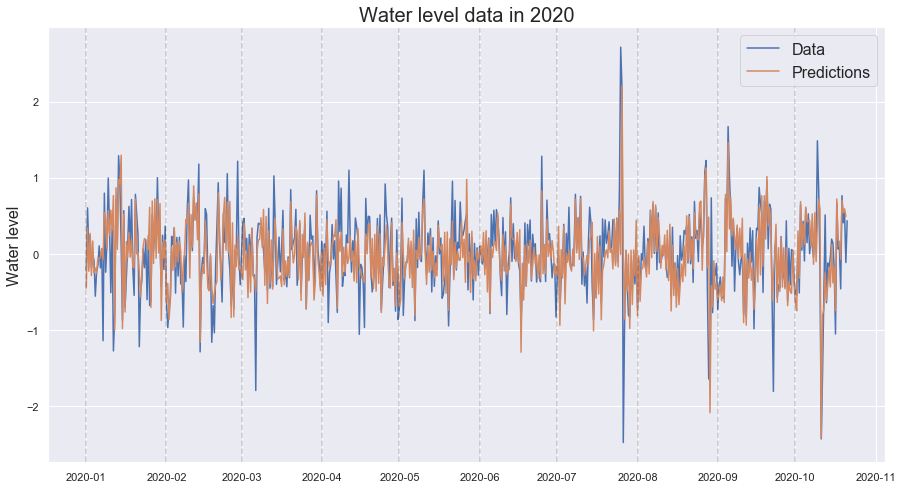

In [216]:
plot_prediction(wl_test, sarimax_25_full_pred_df)

eval_sarimax_25_full = evaluate(wl_test[:len(sarimax_25_full_pred_df)], sarimax_25_full_pred_df, 'SARIMAX(0,1,0)(1,0,1,25) + WS-WLS-AT')
eval_sarimax_25_full

# Save and restore prediction results

Since it takes forever to train and predict, I save them all onto files, so we can still have the prediction results after we restart the kernel.

In [231]:
# save predictions
sarima_24_pred_df.to_csv('1.csv')
sarima_25_pred_df.to_csv('2.csv')
sarima_0_24_pred_df.to_csv('3.csv')
sarima_0_25_pred_df.to_csv('4.csv')
sarima_664_pred_df.to_csv('5.csv')
sarimax_25_full_pred_df.to_csv('6.csv')

In [35]:
# restore predictions
def read_predictions(filepath):
    df = pd.read_csv(filepath)
    df['Date Time'] = pd.to_datetime(df['Date Time'])
    df = df.set_index('Date Time')
    return df

sarima_24_pred_df = read_predictions('1.csv')
sarima_25_pred_df = read_predictions('2.csv')
sarima_0_24_pred_df = read_predictions('3.csv')
sarima_0_25_pred_df = read_predictions('4.csv')
sarima_664_pred_df = read_predictions('5.csv')
sarimax_25_full_pred_df = read_predictions('6.csv')

# Final evaluation

In [234]:
eval_final = pd.concat([eval_sarima_24, eval_sarima_25, eval_sarima_0_24, eval_sarima_0_25, eval_sarima_664, eval_sarimax_24_wind, eval_sarimax_25_full])
eval_final.to_csv('metrics.csv')
eval_final

,MSE,RMSE,R2,MAE,MedAE,MaxErr,Un-difference?
"SARIMA(0,1,0)(1,0,1,24)",0.285,0.534,0.021,0.351,0.195,4.260,False
"SARIMA(0,1,0)(1,0,1,25)",0.390,0.625,-0.373,0.434,0.293,3.476,False
"SARIMA(0,0,0)(1,0,1,24)",0.706,0.840,-0.239,0.670,0.569,2.865,True
"SARIMA(0,0,0)(1,0,1,25)",0.611,0.782,-0.027,0.632,0.557,2.817,True
"SARIMA(0,1,0)(6,0,6,4)",0.225,0.475,-1.664,0.331,0.235,2.797,False
"SARIMAX(0,1,0)(1,0,1,24) + Wind",0.407,0.638,-0.588,0.475,0.389,NaN,False
"SARIMAX(0,1,0)(1,0,1,25) + WS-WLS-AT",0.150,0.387,0.244,0.252,0.162,2.725,False


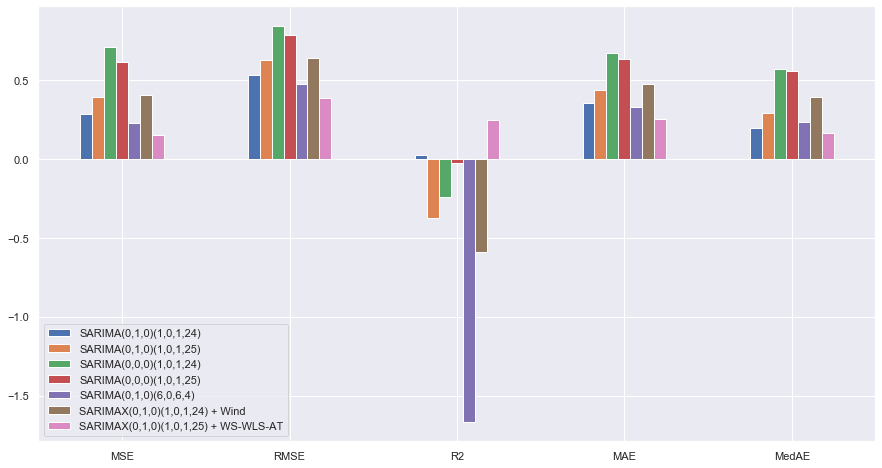

In [260]:
eval_final.loc[:,'MSE':'MedAE'].T.plot(kind='bar', figsize=(15,8), rot=0)

1. I could only undo the differencing on the 3rd and 4th models, so it might be more trustworthy than those first 2 models. The last 3 models might have a significant change (probably declining) if I undeference them properly.
2. Even though (6,0,6)<sub>4</sub> has a much lower AIC scores than other models, its result is not much better than the (1,0,1)<sub>24</sub>, and actually much worse for the R<sup>2</sup> metric.
3. SARIMAX with only wind-related features makes almost no difference compared to (1,0,1)<sub>24</sub>. Its evaluation, however, is conducted on all test data, not just noon and midnight, since I forgot to save the prediction result.
4. The SARIMAX model, with Wind Speed, Water Level Sigma, and Air Temperature as its exogenous variables, has the most promising result out of all models, lowest errors on all metrics, while highest on R<sup>2</sup> metric (but still only at 0.244, which obviously is pretty low).

After all, I consider the result to be really disappointing. The SARIMA is specifically designed for time series, so I anticpated way higher than these. I'd suspect there must be something incorrect in my implementation, probably due to over-deferencing issue and/or poor choices of parameteres.